In [3]:
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q -r comext_graph_analysis/requirements.txt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import trange, tqdm
sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/COMEXT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df_full, _ = g.load_filtered_data("full", save=True, types=g.full_types, columns=g.full_columns, group_by_prod_code=False,
                n_digits=2, years=[y for y in range(2001,2022)], months="all", product=["TOTAL"],
                flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded


In [5]:
df_all = pd.DataFrame(columns=['PRODUCT_CPA2_1', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD',
       'VALUE_IN_EUROS', 'QUANTITY_IN_KG', 'country_from', 'country_to',
       '2020', 'VALUE_IN_EUROS_SCALED', 'VALUE_IN_EUROS_RESCALED',
       'QUANTITY_IN_KG_SCALED', 'QUANTITY_IN_KG_RESCALED'])
df_pop, _ = g.load_population_df()
for y in tqdm(df_full.PERIOD.unique()):
    df_ = df_full[df_full.PERIOD == y]
    df_sc = g.extract_table_for_graph(df_, y=y[:-2], pop_df=df_pop, flow="all", scale_by="population", threshold_cs=0.9999)
    df_all = pd.concat([df_all,df_sc])

  0%|          | 0/252 [00:00<?, ?it/s]

In [14]:
df = df_all[["country_from","country_to","PERIOD"]].copy()

In [7]:
df.shape[0] / df_full.shape[0]

0.6833406115962312

In [8]:
COD = set(df.country_from.unique()).union(set(df.country_to.unique()))
TIMES = sorted(df.PERIOD.unique())
dt = {}
for i, t in enumerate(TIMES):
  dt[t] = i

def get_dt(t):
  return dt[t]

d = {}
for i, cod in enumerate(COD):
  d[cod] = i

def get_d(cod):
  return d[cod]

df["country_from_2"] = df.country_from.apply(get_d)
df["country_to_2"] = df.country_to.apply(get_d)
df["PERIOD_2"] = df.PERIOD.apply(get_dt)
# df2 = df.groupby(["country_to_2","country_from_2","PERIOD_2"],as_index=False).count().sort_values("PERIOD",ascending=False)
df2 = df[~df[["country_from","country_to","PERIOD"]].duplicated()].copy()

In [9]:
df2

,country_from,country_to,PERIOD,country_from_2,country_to_2,PERIOD_2
0,BE,GI,201405,172,90,160
1,ES,GI,201405,221,90,160
2,IT,VA,201405,139,185,160
3,DK,MH,201405,174,137,160
4,IT,GI,201405,139,90,160
...,...,...,...,...,...,...
7870,AT,KH,202112,75,209,251
7875,SM,IE,202112,24,152,251
7876,LV,JO,202112,123,249,251
7878,BG,AR,202112,203,166,251


In [19]:
# Creating X(i,j,t)
X = np.zeros((len(COD),len(COD),len(TIMES)),dtype=np.int8)
n = len(TIMES)
for edge in tqdm(df2[["country_from_2","country_to_2","PERIOD_2"]].values):
    X[edge[0], edge[1], edge[2]] = 1
    X[edge[1], edge[0], edge[2]] = 1 # symmetric
    # X[edge[0], edge[0], t] = 0 # noselfloop
    # X[edge[1], edge[1], t] = 0 # noselfloop

  0%|          | 0/1584112 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa43a381b10>]],
      dtype=object)

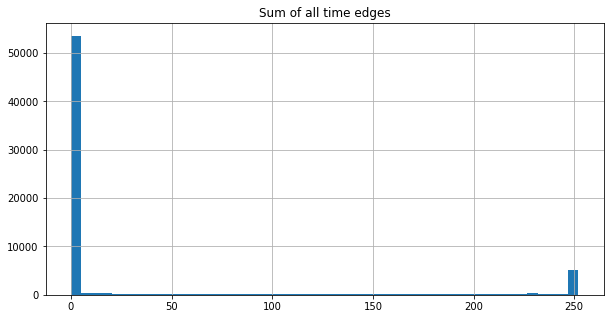

In [20]:
diff = 0
sums = []
for c1 in tqdm(d):
    for c2 in d:
        s = X[d[c1],d[c2],:].sum()
        sums.append(s)
        if s != len(TIMES) and s != 0:
            # print(c1,c2)
            diff += 1
sums = np.array(sums)
pd.DataFrame(sums,columns=["Sum of all time edges"]).hist(bins=50,figsize=(10,5))

alpha = P(from 

In [65]:
# Estimation alpha
N_a = ((X[:,:,1:n] * (1 - X[:,:,0:n-1])).sum(axis=2))
D_a = ((1 - X[:,:,0:n-1])).sum(axis=2)
#0/0=1 > N=0 and D=0  N!=0 or D =!0
# alpha_ij_estimate = np.divide(N_a, D_a, where = np.logical_or(D_a != 0, N_a != 0))
alpha_ij_estimate = np.divide(N_a, D_a, where = (D_a != 0))
# Estimation beta
N_b = ((1 - X[:,:,1:n]) * X[:,:,0:n-1]).sum(axis=2)
D_b = ((X[:,:,0:n-1])).sum(axis=2)
# beta_ij_estimate = np.divide(N_b, D_b, where = np.logical_or(D_b ! = 0, N_b!=0))
beta_ij_estimate = np.divide(N_b, D_b, where = (D_b != 0))
print(alpha_ij_estimate.sum(),beta_ij_estimate.sum())
print(((alpha_ij_estimate + beta_ij_estimate) > 1).sum())

alpha_ij_estimate = np.where(
    np.logical_and(
        N_a==0,
        D_a==0),
    1, alpha_ij_estimate)

beta_ij_estimate = np.where(
    np.logical_and(
        N_b==0,
        D_b==0),
    1, beta_ij_estimate)

print(alpha_ij_estimate.sum(), beta_ij_estimate.sum())

print(((alpha_ij_estimate + beta_ij_estimate) > 1).sum())

6983.3071294354895 3268.9819142947836
2084
6981.928643379713 55953.98191429478
2088
